<a href="https://colab.research.google.com/github/semaHbo/job-clustering-salary-prediction/blob/main/model_training_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("GBT Model Eğitimi - Enriched Data") \
    .getOrCreate()

Mounted at /content/drive


In [ ]:

df = spark.read.parquet("/content/drive/MyDrive/datasets/df_enriched.parquet")

df.select("Pozisyon", "Remote_Tipi", "Kita", "Yil", "Log_Maas_USD").show(5, truncate=False)


+-------------+-----------+-------------+----+------------------+
|Pozisyon     |Remote_Tipi|Kita         |Yil |Log_Maas_USD      |
+-------------+-----------+-------------+----+------------------+
|Data Engineer|Hibrit     |Bilinmeyen   |2020|11.213589077374968|
|Data Engineer|Uzaktan    |Kuzey Amerika|2020|11.571203807011969|
|Data Engineer|Uzaktan    |Kuzey Amerika|2020|11.608244735642321|
|Data Engineer|Uzaktan    |Kuzey Amerika|2020|11.781432363235949|
|Data Engineer|Uzaktan    |Kuzey Amerika|2021|11.849404844423074|
+-------------+-----------+-------------+----+------------------+
only showing top 5 rows



In [ ]:
#Gerekli Dönüşümleri Uygula
from pyspark.ml.feature import Tokenizer, Word2Vec

# Tokenizer
tokenizer = Tokenizer(inputCol="Pozisyon", outputCol="pozisyon_token")
df = tokenizer.transform(df)

# Word2Vec
w2v = Word2Vec(
    inputCol="pozisyon_token",
    outputCol="pozisyon_vec",
    vectorSize=10,
    minCount=1,
    seed=42
)

w2v_model = w2v.fit(df)
df = w2v_model.transform(df)

In [ ]:
#StringIndexer ile kategorik verileri dönüştür
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(inputCol="Deneyim_Seviyesi", outputCol="Deneyim_Seviyesi_Encoded"),
    StringIndexer(inputCol="Calisma_Tipi", outputCol="Calisma_Tipi_Encoded"),
    StringIndexer(inputCol="Sirket_Buyuklugu", outputCol="Sirket_Buyuklugu_Encoded"),
    StringIndexer(inputCol="Sirket_Ulke", outputCol="Sirket_Ulke_Encoded"),
    StringIndexer(inputCol="Remote_Tipi", outputCol="Remote_Tipi_Encoded"),
    StringIndexer(inputCol="Kita", outputCol="Kita_Encoded")
]

for indexer in indexers:
    df = indexer.fit(df).transform(df)


In [ ]:
#Tüm özellikleri birleştir
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "pozisyon_vec",
        "Deneyim_Seviyesi_Encoded",
        "Calisma_Tipi_Encoded",
        "Sirket_Buyuklugu_Encoded",
        "Sirket_Ulke_Encoded",
        "Remote_Tipi_Encoded",
        "Kita_Encoded",
        "Yil"
    ],
    outputCol="features_enriched"
)

df_final = assembler.transform(df)

In [ ]:
from pyspark.sql.functions import monotonically_increasing_id

# row_id ekle
df_final = df_final.withColumn("row_id", monotonically_increasing_id())
train_df = spark.read.parquet("/content/drive/MyDrive/datasets/train_df.parquet").withColumn("row_id", monotonically_increasing_id())
test_df = spark.read.parquet("/content/drive/MyDrive/datasets/test_df.parquet").withColumn("row_id", monotonically_increasing_id())

# Sadece ihtiyacımız olan sütunlar: features_enriched + row_id + Log_Maas_USD
df_selected = df_final.select("row_id", "features_enriched", "Log_Maas_USD")

# Join işlemi
train_df_final = train_df.drop("Log_Maas_USD").join(df_selected, on="row_id", how="inner")
test_df_final = test_df.drop("Log_Maas_USD").join(df_selected, on="row_id", how="inner")


In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

#Modeli tanımla
gbt = GBTRegressor(
    featuresCol="features_enriched",
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    maxDepth=5,
    maxBins=128,
    maxIter=100,
    seed=42
)

#  Modeli eğit
model = gbt.fit(train_df_final)

# Test seti üzerinde tahmin yap
predictions = model.transform(test_df_final)

In [ ]:
evaluator_r2 = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="r2"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="rmse"
)

evaluator_mae = RegressionEvaluator(
    labelCol="Log_Maas_USD",
    predictionCol="prediction",
    metricName="mae"
)

r2 = evaluator_r2.evaluate(predictions)
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print("GBT Model Performansı (Enriched Features):")
print(f"R²     : {round(r2, 4)}")
print(f"RMSE   : {round(rmse, 4)}")
print(f"MAE    : {round(mae, 4)}")

GBT Model Performansı (Enriched Features):
R²     : 0.8623
RMSE   : 0.2918
MAE    : 0.1541


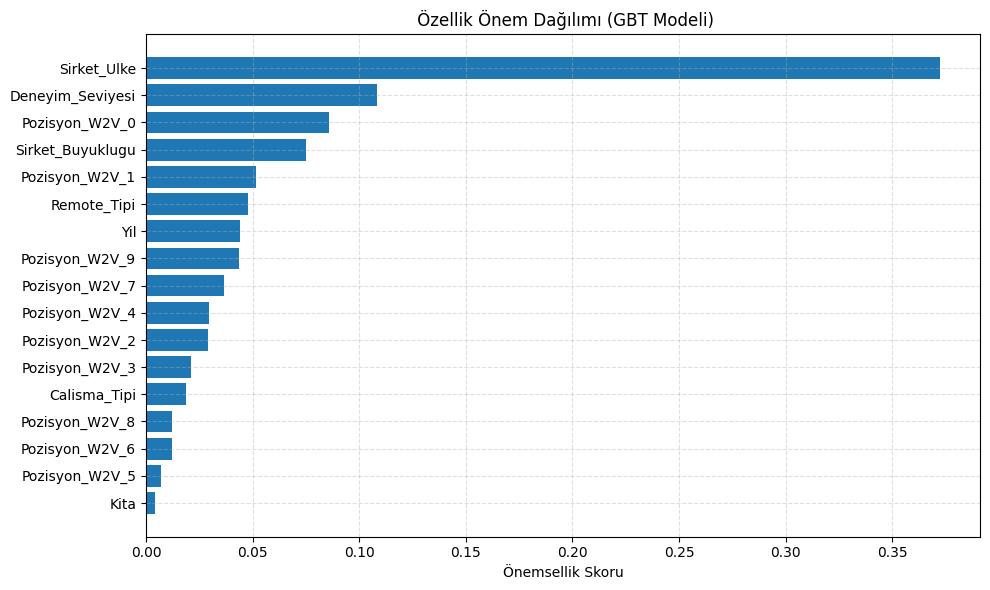

In [ ]:
#Önem Dagilimi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# GBT modelinden importance değerlerini al
importances = model.featureImportances.toArray()

# Word2Vec pozisyon vektörü 10 boyutlu
pozisyon_vec_names = [f"Pozisyon_W2V_{i}" for i in range(10)]

# Diğer sütunlar sırayla aynı şekilde eklendi
other_feature_names = [
    "Deneyim_Seviyesi",
    "Calisma_Tipi",
    "Sirket_Buyuklugu",
    "Sirket_Ulke",
    "Remote_Tipi",
    "Kita",
    "Yil"
]

# Tüm feature adlarını birleştir
feature_names = pozisyon_vec_names + other_feature_names

# Pandas DataFrame'e aktar
importance_df = pd.DataFrame({
    "Özellik": feature_names,
    "Önemi": importances
}).sort_values("Önemi", ascending=False)

# Grafikle göster
plt.figure(figsize=(10,6))
plt.barh(importance_df["Özellik"], importance_df["Önemi"])
plt.gca().invert_yaxis()
plt.title(" Özellik Önem Dağılımı (GBT Modeli)")
plt.xlabel("Önemsellik Skoru")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


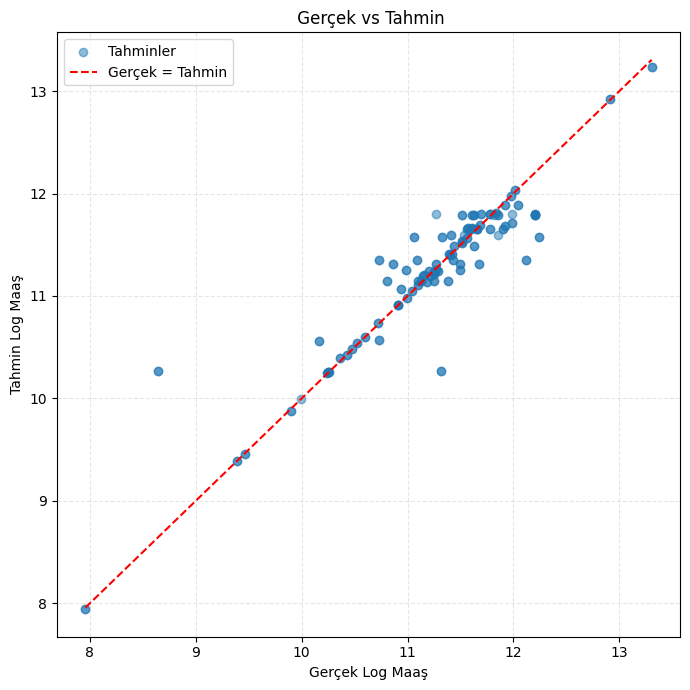

In [ ]:
# Tahmin sonuçlarını pandas'a aktar
pred_df = predictions.select("Log_Maas_USD", "prediction").toPandas()

# Grafik çiz
plt.figure(figsize=(7, 7))
plt.scatter(pred_df["Log_Maas_USD"], pred_df["prediction"], alpha=0.5, label="Tahminler")
plt.plot([pred_df["Log_Maas_USD"].min(), pred_df["Log_Maas_USD"].max()],
         [pred_df["Log_Maas_USD"].min(), pred_df["Log_Maas_USD"].max()],
         color='red', linestyle='--', label="Gerçek = Tahmin")
plt.xlabel("Gerçek Log Maaş")
plt.ylabel("Tahmin Log Maaş")
plt.title(" Gerçek vs Tahmin")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()
